
# Data Preparation

## Imports

In [1]:
import os.path
from os.path import isfile, join
import os
from os import listdir
from osgeo import gdal
import errno
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

In [2]:
# for coloured print statements
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [23]:
path_labels = os.getcwd() + "/1_labeled_data/tif/"
path_rdg = "/home/jovyan/work/satellite_data/"
cutouts_path = os.getcwd() + "/2_cutouts/"

In [4]:
def print_files(path = os.getcwd()):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    print(path, onlyfiles)
print_files(path_labels)

/home/jovyan/work/saved_data/Semantic_Segmentation_of_Tree_Stock/1_labeled_data/tif/ ['22-01-05-uploaded.tif', '22-01-05.TIF', 'check-labels-jp2-capizalized-22-01-05.TIF', 'labels-jp2-tif-22.01-05.tif', '22-01-05-test-3-without-tif.tif', 'now.tif', '22-01-30.tif', '22-01-06-with-tif.tif']


### 0.1 Data Inspection

In [5]:
# Import Image with GDAL
dataset = gdal.Open(path_rdg + "2629BD_2018.tif")

In [6]:
# General Dataset Information
def inspect_tif(dataset):
    # print("1. General TIF Data:")
    # print("Metadata:",7 dataset.GetMetadata())
    # print("Type Image: ", type(dataset))
    # print("Projection: ", dataset.GetProjection())
    # print("Size is {} x {} x {}".format(dataset.RasterXSize,
    #                                 dataset.RasterYSize,
    #                                 dataset.RasterCount))
    # print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
    #                         dataset.GetDriver().LongName))
    # geotransform = dataset.GetGeoTransform()
    # if geotransform:
    #     print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    #     print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

    # Raster Band
    band = dataset.GetRasterBand(1)
    # print("2. Raster Band:")
    # print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

    min = band.GetMinimum()
    max = band.GetMaximum()
    if not min or not max:
        (min,max) = band.ComputeRasterMinMax(True)
    print("Min={:.3f}, Max={:.3f}".format(int(min),int(max)))

    if band.GetOverviewCount() > 0:
        print("Band has {} overviews".format(band.GetOverviewCount()))

    # if band.GetRasterColorTable():
    #     print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))
        
    size_x_px = dataset.RasterXSize
    size_y_px = dataset.RasterYSize
    pixel_size = (dataset.GetGeoTransform()[1], dataset.GetGeoTransform()[1])
    size_x = size_x_px * pixel_size[0]
    size_y = size_y_px * pixel_size[1]
    print("# Pixels in Image = ({}, {}) with a Raster Count of {}".format(size_x_px, size_y_px, dataset.RasterCount))
    print("Size of one Pixel in cm = {}".format(tuple([100*x for x in pixel_size])))
    print("Size Covered by Image / Image Size = ({}m, {}m) -- still faulty atm".format(round(size_x, 4), round(size_y, 4)))
inspect_tif(dataset)

Min=0.000, Max=255.000
Band has 8 overviews
# Pixels in Image = (108224, 107798) with a Raster Count of 3
Size of one Pixel in cm = (0.00023728143101288307, 0.00023728143101288307)
Size Covered by Image / Image Size = (0.2568m, 0.2558m) -- still faulty atm


In [7]:
some_dataset = gdal.Open(path_rdg + "2627DC_2018.tif")
inspect_tif(some_dataset)

Min=0.000, Max=240.000
Band has 8 overviews
# Pixels in Image = (107608, 107249) with a Raster Count of 3
Size of one Pixel in cm = (0.00023770193857792506, 0.00023770193857792506)
Size Covered by Image / Image Size = (0.2558m, 0.2549m) -- still faulty atm


In [8]:
# optional conversion to np array
# channel = np.array(dataset.GetRasterBand(1).ReadAsArray())
# print(channel.shape)

In [9]:
# Read the raster band as separate variable
#band = dataset.GetRasterBand(1)

# Check type of the variable 'band'
#type(band)

# Data type of the values
#gdal.GetDataTypeName(band.DataType)

In [10]:
# band1 = labels.GetRasterBand(1) # Red channel
# band2 = labels.GetRasterBand(2) # Green channel
# band3 = labels.GetRasterBand(3) # Blue channel

In [11]:
#labels.GetRasterBand()

Idea Training Process:
1. Load training set (labels with corresponding input TIFs)
2. Create cutouts of labeled training data
3. Train model on data
4. Evaluate model

Idea Prediction Process:
5. Create cutouts of unlabeled data
6. Predict cutouts

Function Overview
Training: load labels -> create_cutouts(label_file) -> fit(unlabeled_cutouts, labeled_cutouts) -> evaluate(?)
Prediction: load dats -> create_cutouts(label_file) -> predict(unlabeled_cutouts)

In [12]:
def isfile(filepath: str = None):
    # if filepath does not exists, an error is thrown
    if not os.path.isfile(filepath): raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filepath) #print("File does not exist.")

In [13]:
def preview_tif(tif_filepath: str = None):
    isfile(tif_filepath)
    img = rasterio.open(tif_filepath)
    if img: show(img)
    else: print("img unable to be loaded at this moment")

In [14]:
def create_cutouts(path_label, label_file):
    # upper/lower (u/l) left/right (l/r) coordinates 
    ulx, xres, xskew, uly, yskew, yres  = label_file.GetGeoTransform()
    width, height = label_file.RasterXSize, label_file.RasterYSize
    lrx = ulx + width * xres
    lry = uly + height * yres
    # corner & cener coordinates can be checked in the terminal with 
    # $ gdalinfo '/home/jovyan/work/satellite_data/FILE.tif'
    # determine cutout window of size: 512x512 px
    cutout_size = 512
    
    no_of_x_cutouts = 2 # int(width / cutout_size)
    no_of_y_cutouts = 2 # int(height / cutout_size)
    
    for cutout_y in range(no_of_y_cutouts):
        for cutout_x in range(no_of_y_cutouts):
            # ul_corner = (ulx, uly)
            # lr_corner = (lrx, lry)
            # base value (upper left corner of image + how far the cutout is moved in each iteration
            crop_ulx = ulx + (cutout_x * cutout_size)
            crop_uly = uly + (cutout_y * cutout_size)
            # base value (upper left corner of defined cutout) + cutout size
            crop_lrx = crop_ulx + cutout_size * xres
            crop_lry = crop_uly + cutout_size * yres

            cropped_window = (crop_ulx,crop_uly,crop_lrx,crop_lry)
            print("cropped window:", cropped_window)
            # export cropped raster
            cutout_filename = path_label.replace(".tif", "") + "-{}-{}.tif".format(cutout_x, cutout_y)
            cutout_path = cutouts_path + cutout_filename
            # print(f"Cutout: {bcolors.OKBLUE}{cutout_path}{bcolors.ENDC}")
            gdal.Translate(cutout_path, label_file, projWin = cropped_window) #label_file is the tif file

            # preview tif
            #load_tif([cutout_path])
            cutout = gdal.Open(cutout_path)
            # check if gdal is able to open file
            if cutout:
                print(f"{bcolors.OKGREEN}0 Success:{bcolors.ENDC} {bcolors.OKBLUE}{cutout_filename}{bcolors.ENDC}") # complete path: cutout_path
                inspect_tif(cutout)
            preview_tif(cutout_path)

    # close tif
    cutout_path, label_file, cropped_window = None, None, None

In [15]:
def load_tif(files_list: list = None, is_label: bool = False):
    # loop through array of file names
    for filename in files_list:
        complete_filepath = (path_labels if is_label else path_rdg) + filename
        # check if filepath exists
        if not os.path.isfile(complete_filepath):
            print("Filepath does not exist: {}".format(complete_filepath)) 
            continue
        # open file
        label_file = gdal.Open(complete_filepath)
        # check if gdal is able to open file
        if label_file:
            # print(f"{bcolors.OKBLUE}{filename}{bcolors.ENDC}")
            print(f"{bcolors.OKGREEN}0 Success:{bcolors.ENDC} {bcolors.OKBLUE}{filename}{bcolors.ENDC}") # complete path: complete_filepath
            inspect_tif(label_file)
            # if is_label:
            print(f"{bcolors.UNDERLINE}Cutouts:{bcolors.ENDC}")
            # create cutouts
            create_cutouts(filename, label_file)
            continue
        print(f"{bcolors.FAIL}1 Failure:{bcolors.ENDC}" + complete_filepath) #"File cannot be loaded." #"Filepath exists: ", os.path.isfile(tif_filepath), 

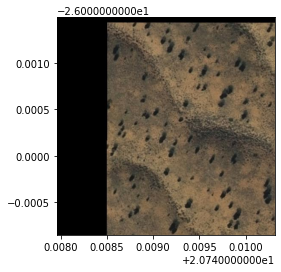

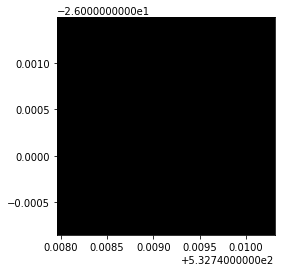

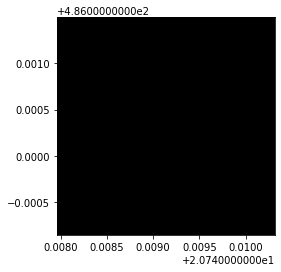

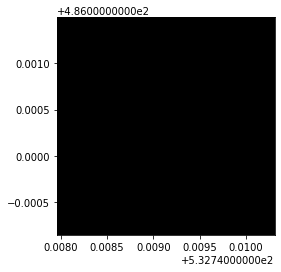

In [42]:
for img_y in range(2):
    for img_x in range(2):
        preview_tif(cutouts_path + "2620BB_2016-{}-{}.tif".format(img_x, img_y))

### 0.2 Load Labels

In [17]:
label_files = ["22-01-30.tif"] #, "now.tif"

0 Success: 22-01-30.tif
Min=80.000, Max=255.000
# Pixels in Image = (4112, 11377) with a Raster Count of 4
Size of one Pixel in cm = (0.0015679484435797747, 0.0015679484435797747)
Size Covered by Image / Image Size = (0.0645m, 0.1784m) -- still faulty atm
Cutouts:
cropped window: (29.748224553, -26.248672807786964, 29.756252449031127, -26.25670070381809)
0 Success: 22-01-30-0-0.tif
Min=80.000, Max=255.000
# Pixels in Image = (512, 512) with a Raster Count of 4
Size of one Pixel in cm = (0.0015679484435797747, 0.0015679484435797747)
Size Covered by Image / Image Size = (0.008m, 0.008m) -- still faulty atm


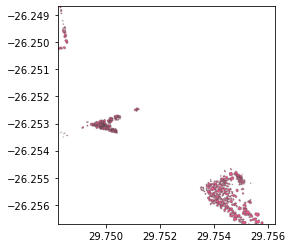

cropped window: (541.748224553, -26.248672807786964, 541.7562524490311, -26.25670070381809)
0 Success: 22-01-30-1-0.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 4
Size of one Pixel in cm = (0.0015679484435797747, 0.0015679484435797747)
Size Covered by Image / Image Size = (0.008m, 0.008m) -- still faulty atm


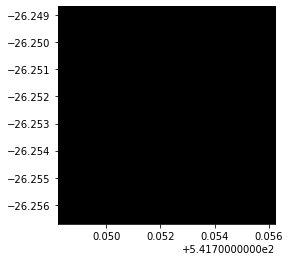

cropped window: (29.748224553, 485.751327192213, 29.756252449031127, 485.7432992961819)
0 Success: 22-01-30-0-1.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 4
Size of one Pixel in cm = (0.0015679484435797747, 0.0015679484435797747)
Size Covered by Image / Image Size = (0.008m, 0.008m) -- still faulty atm


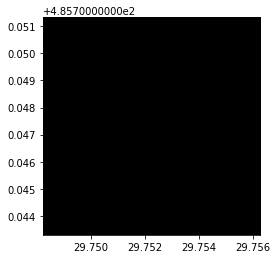

cropped window: (541.748224553, 485.751327192213, 541.7562524490311, 485.7432992961819)
0 Success: 22-01-30-1-1.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 4
Size of one Pixel in cm = (0.0015679484435797747, 0.0015679484435797747)
Size Covered by Image / Image Size = (0.008m, 0.008m) -- still faulty atm


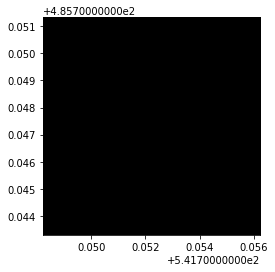

In [18]:
#load_tif(label_files, True)

0 Success: 2620BB_2016.tif
Min=0.000, Max=167.000
Band has 7 overviews
# Pixels in Image = (25631, 55142) with a Raster Count of 3
Size of one Pixel in cm = (0.0004588215890692739, 0.0004588215890692739)
Size Covered by Image / Image Size = (0.1176m, 0.253m) -- still faulty atm
Cutouts:
cropped window: (20.747963002779795, -25.9985051958735, 20.75031216931583, -26.000854362409534)
0 Success: 2620BB_2016-0-0.tif
Min=0.000, Max=177.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.0004588215890692739, 0.0004588215890692739)
Size Covered by Image / Image Size = (0.0023m, 0.0023m) -- still faulty atm


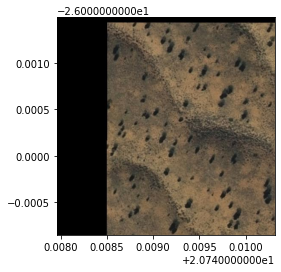

cropped window: (532.7479630027798, -25.9985051958735, 532.7503121693159, -26.000854362409534)
0 Success: 2620BB_2016-1-0.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.0004588215890692739, 0.0004588215890692739)
Size Covered by Image / Image Size = (0.0023m, 0.0023m) -- still faulty atm


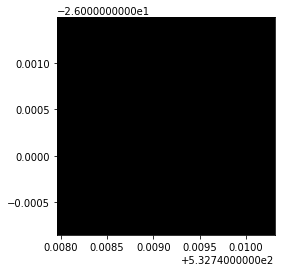

cropped window: (20.747963002779795, 486.0014948041265, 20.75031216931583, 485.99914563759046)
0 Success: 2620BB_2016-0-1.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.0004588215890692739, 0.0004588215890692739)
Size Covered by Image / Image Size = (0.0023m, 0.0023m) -- still faulty atm


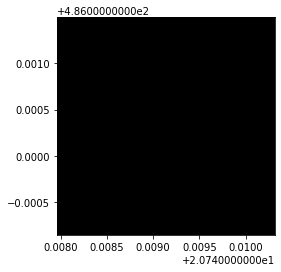

cropped window: (532.7479630027798, 486.0014948041265, 532.7503121693159, 485.99914563759046)
0 Success: 2620BB_2016-1-1.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.0004588215890692739, 0.0004588215890692739)
Size Covered by Image / Image Size = (0.0023m, 0.0023m) -- still faulty atm


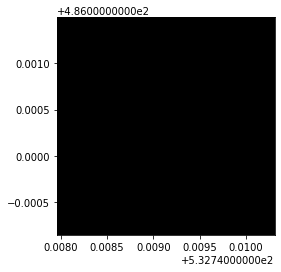

0 Success: 2620BC_2009.tif
Min=0.000, Max=168.000
Band has 7 overviews
# Pixels in Image = (54722, 53527) with a Raster Count of 3
Size of one Pixel in cm = (0.00047458965175858876, 0.00047458965175858876)
Size Covered by Image / Image Size = (0.2597m, 0.254m) -- still faulty atm
Cutouts:
cropped window: (20.497412349675596, -26.24798835403079, 20.499842248692598, -26.250418253047794)
0 Success: 2620BC_2009-0-0.tif
Min=0.000, Max=162.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.00047458965175858876, 0.00047458965175858876)
Size Covered by Image / Image Size = (0.0024m, 0.0024m) -- still faulty atm


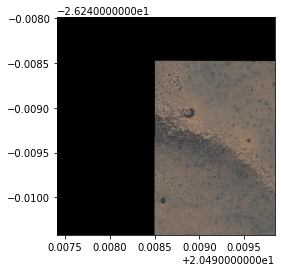

cropped window: (532.4974123496756, -26.24798835403079, 532.4998422486926, -26.250418253047794)
0 Success: 2620BC_2009-1-0.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.00047458965175858876, 0.00047458965175858876)
Size Covered by Image / Image Size = (0.0024m, 0.0024m) -- still faulty atm


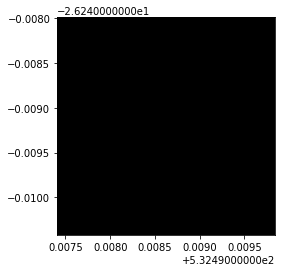

cropped window: (20.497412349675596, 485.7520116459692, 20.499842248692598, 485.74958174695223)
0 Success: 2620BC_2009-0-1.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.00047458965175858876, 0.00047458965175858876)
Size Covered by Image / Image Size = (0.0024m, 0.0024m) -- still faulty atm


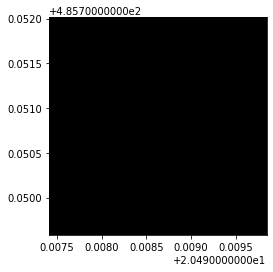

cropped window: (532.4974123496756, 485.7520116459692, 532.4998422486926, 485.74958174695223)
0 Success: 2620BC_2009-1-1.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.00047458965175858876, 0.00047458965175858876)
Size Covered by Image / Image Size = (0.0024m, 0.0024m) -- still faulty atm


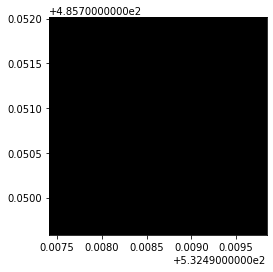

0 Success: 2620BC_2013.tif
Min=0.000, Max=191.000
Band has 7 overviews
# Pixels in Image = (54920, 53718) with a Raster Count of 3
Size of one Pixel in cm = (0.0004745911234076358, 0.0004745911234076358)
Size Covered by Image / Image Size = (0.2606m, 0.2549m) -- still faulty atm
Cutouts:
cropped window: (20.49712351592177, -26.247536074996468, 20.499553422473618, -26.249965981548314)
0 Success: 2620BC_2013-0-0.tif
Min=0.000, Max=182.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.0004745911234076358, 0.0004745911234076358)
Size Covered by Image / Image Size = (0.0024m, 0.0024m) -- still faulty atm


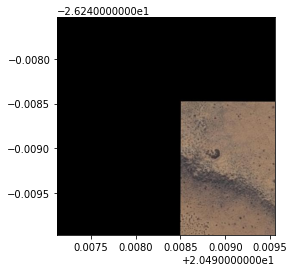

cropped window: (532.4971235159218, -26.247536074996468, 532.4995534224736, -26.249965981548314)
0 Success: 2620BC_2013-1-0.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.0004745911234076358, 0.0004745911234076358)
Size Covered by Image / Image Size = (0.0024m, 0.0024m) -- still faulty atm


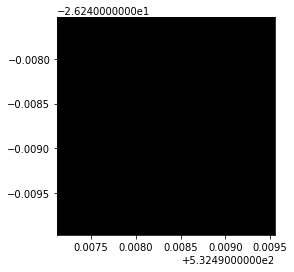

cropped window: (20.49712351592177, 485.75246392500355, 20.499553422473618, 485.7500340184517)
0 Success: 2620BC_2013-0-1.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.0004745911234076358, 0.0004745911234076358)
Size Covered by Image / Image Size = (0.0024m, 0.0024m) -- still faulty atm


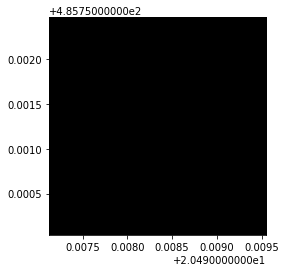

cropped window: (532.4971235159218, 485.75246392500355, 532.4995534224736, 485.7500340184517)
0 Success: 2620BC_2013-1-1.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.0004745911234076358, 0.0004745911234076358)
Size Covered by Image / Image Size = (0.0024m, 0.0024m) -- still faulty atm


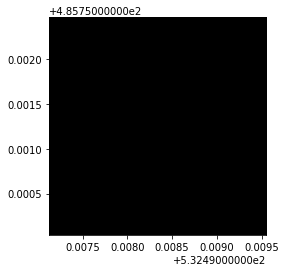

0 Success: 2620BC_2016.tif
Min=0.000, Max=197.000
Band has 7 overviews
# Pixels in Image = (54752, 53526) with a Raster Count of 3
Size of one Pixel in cm = (0.0004746040550983944, 0.0004746040550983944)
Size Covered by Image / Image Size = (0.2599m, 0.254m) -- still faulty atm
Cutouts:
cropped window: (20.497412349675596, -26.247988354030795, 20.4998423224377, -26.2504183267929)
0 Success: 2620BC_2016-0-0.tif
Min=0.000, Max=176.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.0004746040550983944, 0.0004746040550983944)
Size Covered by Image / Image Size = (0.0024m, 0.0024m) -- still faulty atm


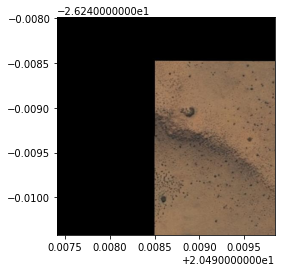

cropped window: (532.4974123496756, -26.247988354030795, 532.4998423224378, -26.2504183267929)
0 Success: 2620BC_2016-1-0.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.0004746040550983944, 0.0004746040550983944)
Size Covered by Image / Image Size = (0.0024m, 0.0024m) -- still faulty atm


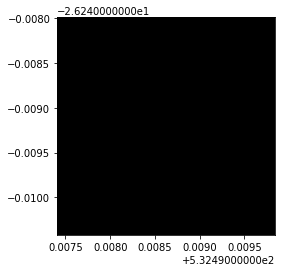

cropped window: (20.497412349675596, 485.7520116459692, 20.4998423224377, 485.7495816732071)
0 Success: 2620BC_2016-0-1.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.0004746040550983944, 0.0004746040550983944)
Size Covered by Image / Image Size = (0.0024m, 0.0024m) -- still faulty atm


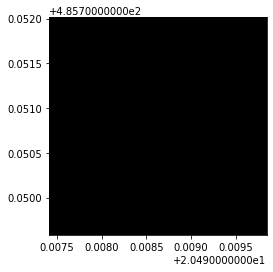

cropped window: (532.4974123496756, 485.7520116459692, 532.4998423224378, 485.7495816732071)
0 Success: 2620BC_2016-1-1.tif
Min=0.000, Max=0.000
# Pixels in Image = (512, 512) with a Raster Count of 3
Size of one Pixel in cm = (0.0004746040550983944, 0.0004746040550983944)
Size Covered by Image / Image Size = (0.0024m, 0.0024m) -- still faulty atm


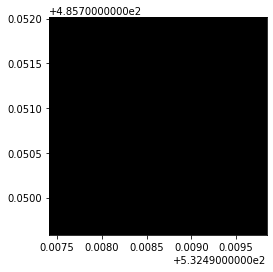

In [19]:
files = ["2620BB_2016.tif"] #, "2620BC_2009.tif", "2620BC_2013.tif", "2620BC_2016.tif"
load_tif(files, False)

# Backlog

In [20]:
#check if all (label) files in a directory are loadable
def check_all_labels(directory = os.fsencode(path_labels)):
    print("Labels")    
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".tif") or filename.endswith(".TIF") or filename.endswith(".tiff"): 
            print(filename)
            load_tif(path_labels + filenyame)
            print("")
            continue
        else:
            continue
#check_all_labels(os.fsencode(path_labels))

In [21]:
# No. of Bands, Image resolution (X, Y), CRS (Coordinate Reference System)
# print(label.count, label.height, label.width, label.crs)